In [17]:
import json, cv2
import numpy as np
from ultralytics.utils.plotting import Annotator, Colors
from ultralytics.utils import ops
from utils import load_image_cv2

In [2]:
image_dir = "/workspace/FishEye8k/dataset/Fisheye8K_all_including_train/test/images/"
gt_dir    = "/workspace/FishEye8k/dataset/Fisheye8K_all_including_train/test/test.json"
pred_dir  = "results/internimage_eval_fisheye_128.json"

In [3]:
with open(gt_dir)   as f: gts   = json.load(f)
with open(pred_dir) as f: preds = json.load(f)

In [56]:
gt_img, g_ann = gts["images"], gts["annotations"]

In [57]:
# get all image_id from the predicitons
img_ids = []
for pred in preds:
  if not pred["image_id"] in img_ids: 
    img_ids.append(pred["image_id"])
print(img_ids)
print(len(img_ids))

[21167, 4360, 1150, 4297, 40348, 11206, 4070, 40536, 42284, 40467, 71466, 11195, 21227, 21139, 11344, 1168, 40214, 43130, 4357, 43423, 42237, 43202, 42126, 71247, 4296, 11357, 40460, 71393, 21215, 71287, 71328, 7113, 40461, 21172, 43429, 40118, 42289, 11114, 71386, 1124, 4235, 43228, 71486, 71245, 21276, 71405, 4348, 1116, 71358, 2185, 4045, 42143, 71307, 11142, 71398, 4286, 4223, 7193, 40496, 43333, 43516, 43376, 71414, 71180, 11379, 40565, 7191, 40246, 7166, 42129, 11280, 71102, 43213, 213, 71288, 1145, 43369, 21209, 1175, 43171, 71349, 40404, 11200, 42183, 40220, 40492, 42225, 11281, 43177, 11373, 40472, 11261, 7194, 4277, 43458, 43326, 1154, 21132, 42282, 71411, 11156, 11269, 11263, 71301, 40361, 40568, 4372, 40407, 7197, 21145, 40403, 71278, 42134, 40264, 1184, 43335, 1166, 43361, 40349, 71437, 43230, 43474, 7173, 4346, 40353, 11329, 71418, 11137]
128


In [60]:
idx = img_ids[20]

filename = [g["file_name"] for g in gt_img if g["id"] == idx]
print(filename[0])
img = cv2.imread(image_dir + filename[0])

# get ground truth
cls = np.array([gt["category_id"] for gt in gt_ann if gt["image_id"] == idx])
bboxes = np.array([gt["bbox"] for gt in gt_ann if gt["image_id"] == idx])
confs = None
# confs = np.array([gt["score"] for gt in gt_ann if gt["image_id"] == idx])

camera4_E_237.png


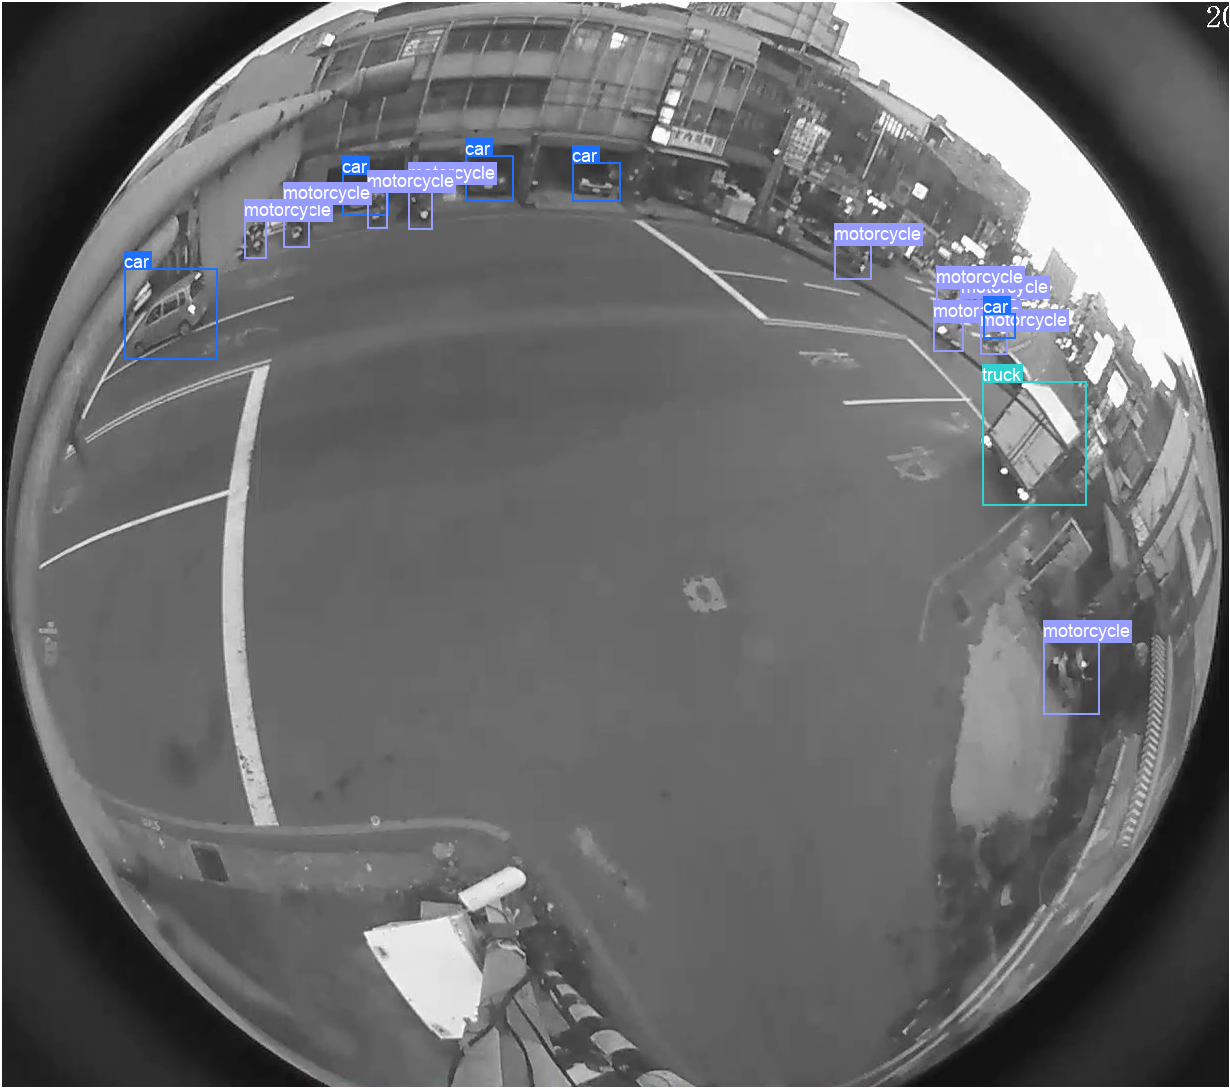

In [74]:
# def plot_images(images, cls, bboxes, conf):
# names  = {0: 'person', 2: 'car', 3: 'motorcycle', 5: 'bus', 7: 'truck'}
names = {0: 'bus', 1: 'motorcycle', 2: 'car', 3: 'person', 4: 'truck'}
colors = Colors()
bs = 1
ns = np.ceil(bs**0.5)
h, w, _ = img.shape 
mosaic = np.full((int(ns * h), int(ns * w), 3), 255, dtype=np.uint8)  # init
i = 0
x, y = int(w * (i // ns)), int(h * (i % ns))  # block origin
mosaic[y : y + h, x : x + w, :] = img

# Resize (optional)
max_size = 1920
scale = max_size / ns / max(h, w)

# Annotate
fs = int((h + w) * ns * 0.008)  # font size
annotator = Annotator(img, line_width=round(fs / 10), font_size=fs, pil=True, example=None)
for i in range(bs):
  x, y = int(w * (i // ns)), int(h * (i % ns))  # block origin
  annotator.rectangle([x, y, x + w, y + h], None, (255, 255, 255), width=2)  # borders
  if len(cls) > 0:
    classes = cls.astype("int")
    labels = confs is None
    
    if len(bboxes):
      boxes = bboxes
      conf = confs if confs is not None else None  # check for confidence presence (label vs pred)
      boxes = ops.ltwh2xyxy(boxes)
      boxes[..., 0::2] += x
      boxes[..., 1::2] += y
      for j, box in enumerate(boxes.astype(np.int64).tolist()):
        c = classes[j]
        color = colors(c)
        c = names[c] if names else c
        if labels or conf[j] > 0.25:  # 0.25 conf thresh
          label = f"{c}" if labels else f"{c} {conf[j]:.1f}"
          annotator.box_label(box, label, color=color, rotated=None)
annotator.show()